In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter

Load data

In [4]:
org_sig_df = pd.read_csv('Dijet_bb_pt20_50_dw.csv')
org_bkg_df = pd.read_csv('Dijet_qq_pt20_50_dw.csv')

Truth matching

In [5]:
sig_df = org_sig_df
bkg_df = org_bkg_df

In [6]:
# Make cuts to data
sig_df = sig_df[sig_df['Jet0_MC_Match'] == 1]
bkg_df = bkg_df[bkg_df['Jet0_MC_Match'] == 1]

sig_df = sig_df[sig_df['Jet0_MC_Jet_EfB'] > 0.6]
bkg_df = bkg_df[bkg_df['Jet0_MC_Jet_EfB'] < 0.6]

bkg_df = bkg_df[bkg_df['Jet0_MC_Jet_EfD'] < 0.6]

Make plots of data before and after truth matching

In [7]:
def plot_before_after_cuts(col, bins):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Make bins the same
    all_data = np.concatenate([org_sig_df[col], org_bkg_df[col], sig_df[col], bkg_df[col]])
    data_min, data_max = np.min(all_data), np.max(all_data)

    bin_edges = np.linspace(data_min, data_max, bins + 1)

    # Before cuts
    ax1.hist(org_sig_df[col], label="Signal", bins=bin_edges, range=(data_min, data_max), histtype='step', color='darkred')
    ax1.hist(org_bkg_df[col], label="Background", bins=bin_edges, range=(data_min, data_max), histtype='step', color='mediumblue')
    ax1.legend(loc='best')
    ax1.set_yscale('log')
    ax1.set_xlabel(f'{col}')
    ax1.set_ylabel('Counts')
    ax1.set_title('Before Truth Matching');

    # After cuts
    ax2.hist(sig_df[col], label="Signal", bins=bin_edges, range=(data_min, data_max), histtype='step', color='darkred')
    ax2.hist(bkg_df[col], label="Background", bins=bin_edges, range=(data_min, data_max), histtype='step', color='mediumblue')
    ax2.legend(loc='best')
    ax2.set_yscale('log')
    ax2.set_xlabel(f'{col}')
    ax2.set_ylabel('Counts')
    ax2.set_title('After Truth Matching');

    plt.tight_layout()
    plt.show()

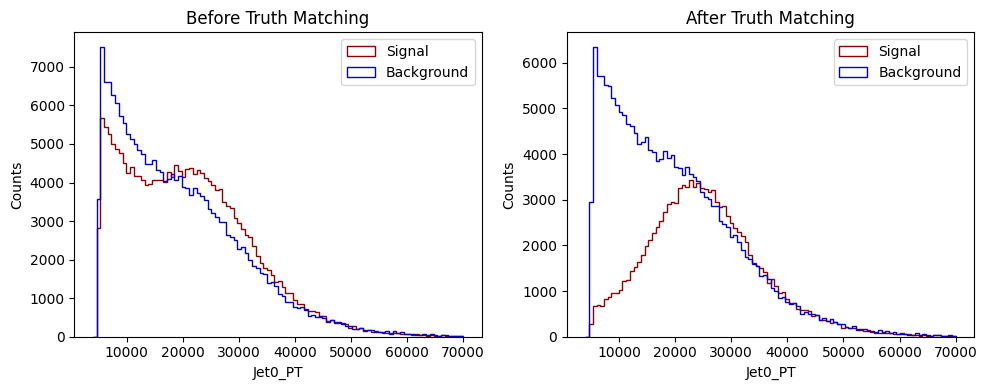

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Make bins the same
all_data = np.concatenate([org_sig_df['Jet0_PT'], org_bkg_df['Jet0_PT'], sig_df['Jet0_PT'], bkg_df['Jet0_PT']])

# Before cuts
ax1.hist(org_sig_df['Jet0_PT'], label="Signal", bins=100, range=[4000,70000], histtype='step', color='darkred')
ax1.hist(org_bkg_df['Jet0_PT'], label="Background", bins=100, range=[4000,70000], histtype='step', color='mediumblue')
ax1.legend(loc='best')
ax1.set_xlabel('Jet0_PT')
ax1.set_ylabel('Counts')
ax1.set_title('Before Truth Matching');

# After cuts
ax2.hist(sig_df['Jet0_PT'], label="Signal", bins=100, range=[4000,70000], histtype='step', color='darkred')
ax2.hist(bkg_df['Jet0_PT'], label="Background", bins=100, range=[4000,70000], histtype='step', color='mediumblue')
ax2.legend(loc='best')
ax2.set_xlabel('Jet0_PT')
ax2.set_ylabel('Counts')
ax2.set_title('After Truth Matching');

plt.tight_layout()
plt.show()

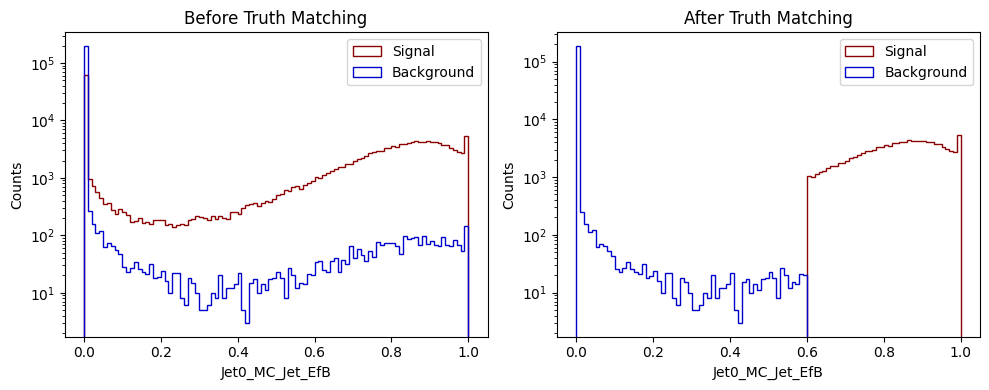

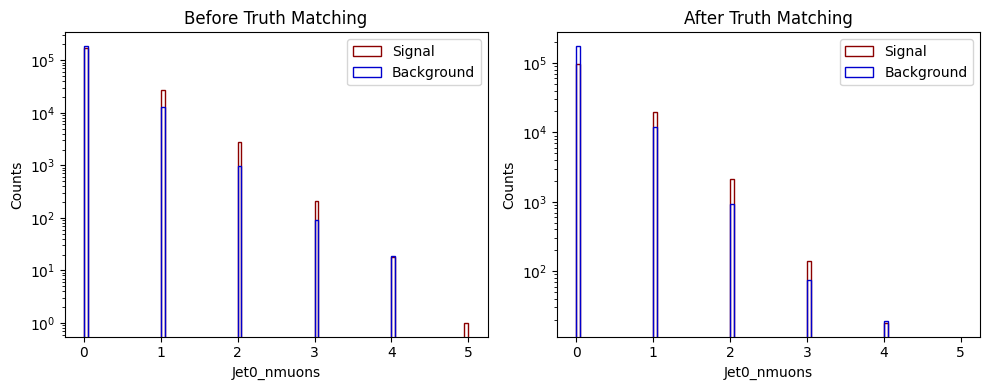

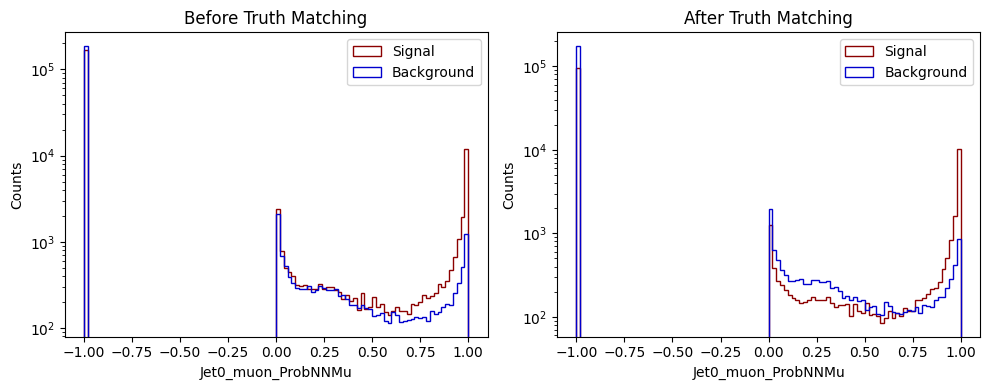

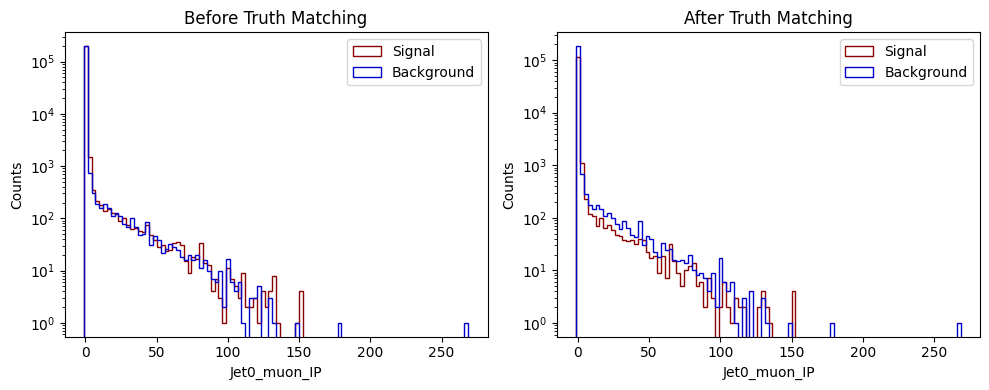

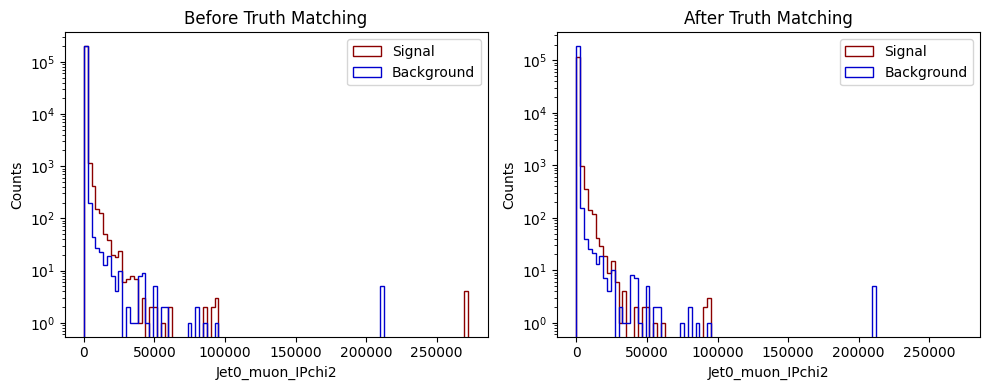

In [9]:
bins = 100
plot_before_after_cuts('Jet0_MC_Jet_EfB', bins)
plot_before_after_cuts('Jet0_nmuons', bins)
plot_before_after_cuts('Jet0_muon_ProbNNMu', bins)
plot_before_after_cuts('Jet0_muon_IP', bins)
plot_before_after_cuts('Jet0_muon_IPchi2', bins)

Plot features data

In [10]:
# Distinguish signal and background
org_sig_df['IsB'] = 1
org_bkg_df['IsB'] = 0

# Separate Jet 0 and Jet 1 data
org_sig_jet0 = org_sig_df[org_sig_df.columns[org_sig_df.columns.str.contains("Jet0|IsB")]]
org_bkg_jet0 = org_bkg_df[org_bkg_df.columns[org_bkg_df.columns.str.contains("Jet0|IsB")]]

org_sig_jet1 = org_sig_df[org_sig_df.columns[org_sig_df.columns.str.contains("Jet1|IsB")]]
org_bkg_jet1 = org_bkg_df[org_bkg_df.columns[org_bkg_df.columns.str.contains("Jet1|IsB")]]

# Combine signal and background and shuffle
org_train_df = pd.concat([org_sig_jet0, org_bkg_jet0]).sample(frac=1, random_state=42).reset_index(drop=True)
org_test_df = pd.concat([org_sig_jet1, org_bkg_jet1]).sample(frac=1, random_state=42).reset_index(drop=True)

In [11]:
# Distinguish signal and background
sig_df['IsB'] = 1
bkg_df['IsB'] = 0

# Separate Jet 0 and Jet 1 data
sig_jet0 = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsB")]]
bkg_jet0 = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsB")]]

sig_jet1 = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet1|IsB")]]
bkg_jet1 = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet1|IsB")]]

# Combine signal and background and shuffle
train_df = pd.concat([sig_jet0, bkg_jet0]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([sig_jet1, bkg_jet1]).sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
# Track/ daughter kinematic features
train_d_cols = [col for col in train_df.columns if "_Daughters" in col]
test_d_cols = [col for col in test_df.columns if "_Daughters" in col]

# Jet input features
train_jet_cols = ['Jet0_Eta', 'Jet0_PT', 'Jet0_nmuons']
test_jet_cols = ['Jet1_Eta', 'Jet1_PT', 'Jet1_nmuons']

# Features columns (daughter kinematics + Eta and pT)
train_f_cols = train_d_cols + train_jet_cols
test_f_cols = test_d_cols + test_jet_cols

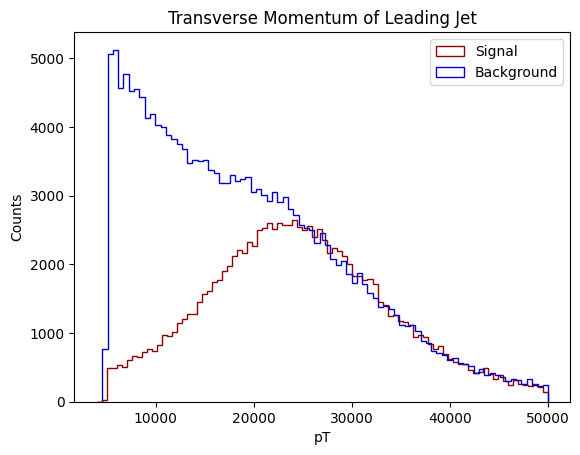

In [13]:
plt.hist(sig_df.Jet0_PT, label="Signal", range=[4000,50000], bins='auto', histtype='step', color='darkred')
plt.hist(bkg_df.Jet0_PT, label="Background", range=[4000,50000], bins='auto', histtype='step', color='mediumblue')
plt.xlabel('pT')
plt.ylabel("Counts")
plt.legend(loc='best')
plt.title('Transverse Momentum of Leading Jet'); 

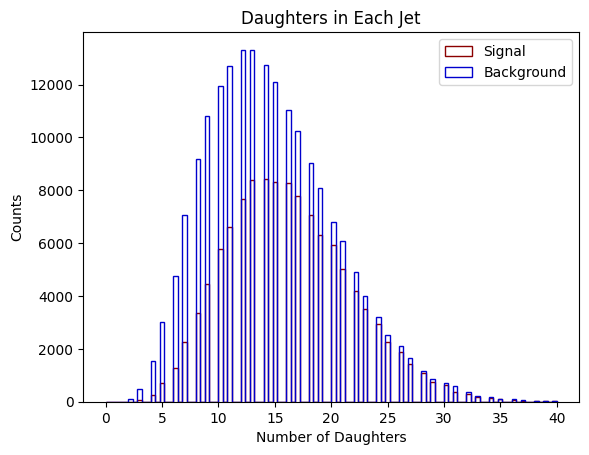

In [14]:
plt.hist(sig_df.Jet0_nDaughters, label="Signal", range=[0,40], bins=100, histtype='step', color='darkred')
plt.hist(bkg_df.Jet0_nDaughters, label="Background", range=[0,40], bins=100, histtype='step', color='mediumblue')
plt.xlabel('Number of Daughters')
plt.ylabel("Counts")
plt.legend(loc='best')
plt.title('Daughters in Each Jet'); 

In [15]:
sig_list = []
bkg_list = []

for i, row in sig_df.iterrows():
    numbers = [float(num.strip()) for num in row['Jet0_Daughters_ID'].strip('[]').split(',')]
    sig_list.extend(numbers)

for i, row in bkg_df.iterrows():
    numbers = [float(num.strip()) for num in row['Jet0_Daughters_ID'].strip('[]').split(',')]
    bkg_list.extend(numbers)

In [16]:
sig_counts = Counter(sig_list)
bkg_counts = Counter(bkg_list)

In [17]:
sig_counts

Counter({22.0: 817321,
         211.0: 350853,
         -211.0: 344808,
         -22.0: 127280,
         310.0: 53388,
         321.0: 44040,
         -321.0: 43600,
         -11.0: 22427,
         11.0: 22010,
         111.0: 17904,
         2212.0: 15657,
         -2212.0: 14602,
         -13.0: 9188,
         13.0: 8766,
         -3122.0: 6431,
         3122.0: 6212})

In [18]:
bkg_counts

Counter({22.0: 1196417,
         211.0: 513585,
         -211.0: 500336,
         -22.0: 195781,
         321.0: 65630,
         -321.0: 62887,
         2212.0: 38168,
         -2212.0: 35961,
         310.0: 35462,
         -11.0: 24817,
         11.0: 24288,
         111.0: 22422,
         -3122.0: 4887,
         3122.0: 4830,
         -13.0: 2287,
         13.0: 2237})

In [19]:
# Daughters PIDs - particles in Jet 0
sig_ids = sorted(list(set(sig_list)))
bkg_ids = sorted(list(set(bkg_list)))

In [20]:
sig_ids

[-3122.0,
 -2212.0,
 -321.0,
 -211.0,
 -22.0,
 -13.0,
 -11.0,
 11.0,
 13.0,
 22.0,
 111.0,
 211.0,
 310.0,
 321.0,
 2212.0,
 3122.0]

In [21]:
bkg_ids

[-3122.0,
 -2212.0,
 -321.0,
 -211.0,
 -22.0,
 -13.0,
 -11.0,
 11.0,
 13.0,
 22.0,
 111.0,
 211.0,
 310.0,
 321.0,
 2212.0,
 3122.0]

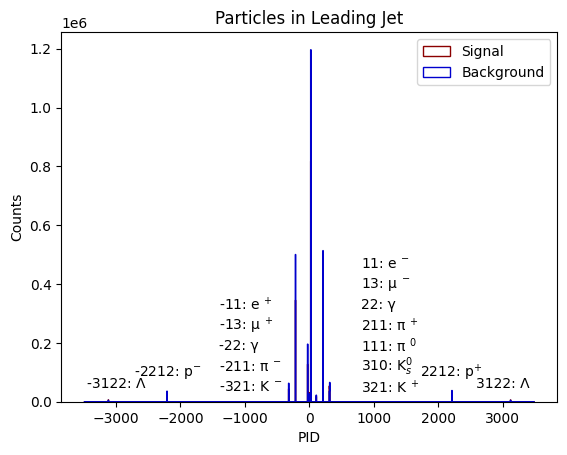

In [22]:
# Plot of Jet 0 Daughters PID (not including some outliers)
plt.hist(sig_list, label='Signal', bins=1000, range=[-3500,3500], histtype='step', color='darkred')
plt.hist(bkg_list, label='Background', bins=1000, range=[-3500,3500], histtype='step', color='mediumblue')

plt.text(-3000, 60000, '-3122: Λ', horizontalalignment='center', verticalalignment='center')
plt.text(-2200, 100000, '-2212: p$^{-}$', horizontalalignment='center', verticalalignment='center')
plt.text(-1400, 50000, '-321: K $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(-1400, 120000, '-211: π $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(-1400, 190000, '-22: γ', horizontalalignment='left', verticalalignment='center')
plt.text(-1400, 260000, '-13: µ $^{+}$', horizontalalignment='left', verticalalignment='center')
plt.text(-1400, 330000, '-11: e $^{+}$', horizontalalignment='left', verticalalignment='center')

plt.text(800, 470000, '11: e $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(800, 400000, '13: µ $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(800, 330000, '22: γ', horizontalalignment='left', verticalalignment='center')
plt.text(800, 260000, '211: π $^{+}$', horizontalalignment='left', verticalalignment='center')
plt.text(800, 190000, '111: π $^{0}$', horizontalalignment='left', verticalalignment='center')
plt.text(800, 120000, '310: K$^{0}_{s}$', horizontalalignment='left', verticalalignment='center')
plt.text(800, 50000, '321: K $^{+}$', horizontalalignment='left', verticalalignment='center')
plt.text(2200, 100000, '2212: p$^{+}$', horizontalalignment='center', verticalalignment='center')
plt.text(3000, 60000, '3122: Λ', horizontalalignment='center', verticalalignment='center')

plt.xlabel('PID');
plt.ylabel('Counts');
plt.title('Particles in Leading Jet');
plt.legend(loc='best');

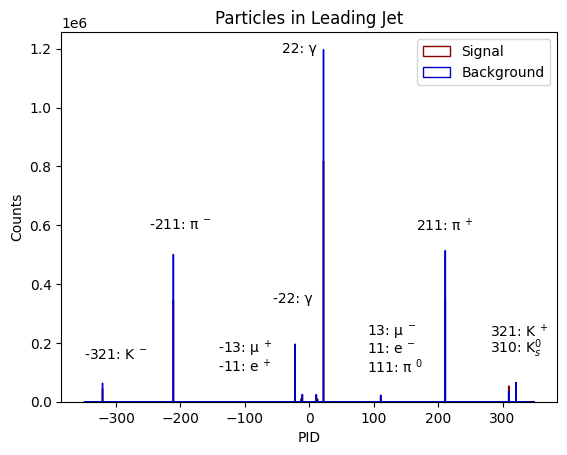

In [23]:
# Plot of Daughters PID in range of pions
plt.hist(sig_list, label='Signal', bins=1000, range=[-350,350], histtype='step', color='darkred')
plt.hist(bkg_list, label='Background', bins=1000, range=[-350,350], histtype='step', color='mediumblue')

plt.text(-300, 160000, '-321: K $^{-}$', horizontalalignment='center', verticalalignment='center')
plt.text(-200, 600000, '-211: π $^{-}$', horizontalalignment='center', verticalalignment='center')
plt.text(-25, 350000, '-22: γ', horizontalalignment='center', verticalalignment='center')
plt.text(-100, 180000, '-13: µ $^{+}$', horizontalalignment='center', verticalalignment='center')
plt.text(-100, 120000, '-11: e $^{+}$', horizontalalignment='center', verticalalignment='center')

plt.text(90, 180000, '11: e $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(90, 240000, '13: µ $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(-15, 1200000, '22: γ', horizontalalignment='center', verticalalignment='center')
plt.text(90, 120000, '111: π $^{0}$', horizontalalignment='left', verticalalignment='center')
plt.text(211, 600000, '211: π $^{+}$', horizontalalignment='center', verticalalignment='center')
plt.text(280, 180000, '310: K$^{0}_{s}$', horizontalalignment='left', verticalalignment='center')
plt.text(280, 240000, '321: K $^{+}$', horizontalalignment='left', verticalalignment='center')

plt.xlabel('PID');
plt.ylabel('Counts');
plt.title('Particles in Leading Jet');
plt.legend(loc='best');

In [24]:
ipchi2_sig_list = []
ipchi2_bkg_list = []

for i, row in sig_df.iterrows():
    numbers = [float(num.strip()) for num in row['Jet0_Daughters_IPCHI2'].strip('[]').split(',')]
    ipchi2_sig_list.extend(numbers)

for i, row in bkg_df.iterrows():
    numbers = [float(num.strip()) for num in row['Jet0_Daughters_IPCHI2'].strip('[]').split(',')]
    ipchi2_bkg_list.extend(numbers)

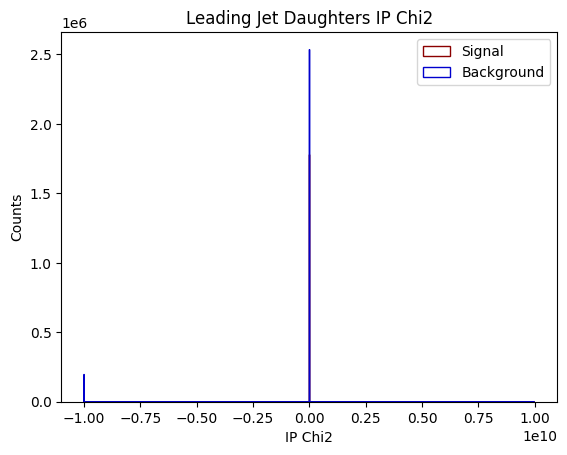

In [26]:
plt.hist(ipchi2_sig_list, label='Signal', bins=1000, range=[-1e10,1e10], histtype='step', color='darkred')
plt.hist(ipchi2_bkg_list, label='Background', bins=1000, range=[-1e10,1e10], histtype='step', color='mediumblue')

plt.xlabel('IP Chi2');
plt.ylabel('Counts');
plt.title('Leading Jet Daughters IP Chi2');
plt.legend(loc='best');

In [ ]:
def make_plots(col, bins, range, scale):

    plt.hist(sig_df[col], label="Signal", bins=bins, range=range, histtype='step', color='darkred')
    plt.hist(bkg_df[col], label="Background", bins=bins, range=range, histtype='step', color='mediumblue')
    plt.legend(loc='best')
    plt.yscale(scale)
    plt.xlabel(f'{col}')
    plt.ylabel('Counts')
    plt.title(f'{col}');

    plt.tight_layout()
    plt.show()

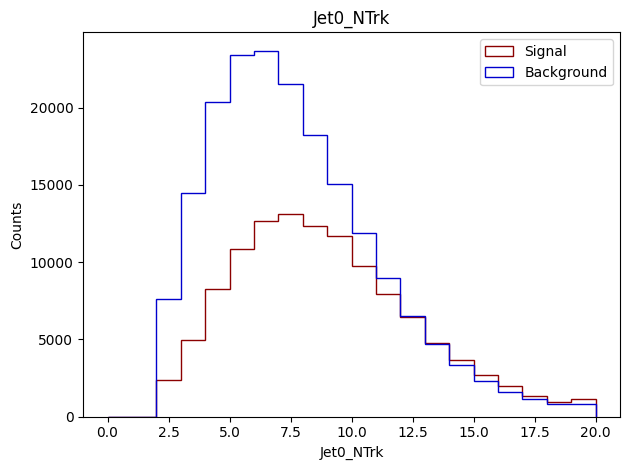

In [ ]:
make_plots('Jet0_NTrk', 20, [0,20], 'linear')

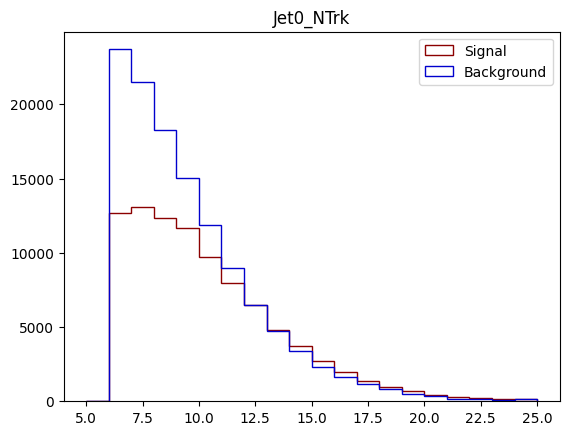

In [ ]:
# only plot Jet0_NTrk > 5
dfcut = sig_df[sig_df.Jet0_NTrk > 5]
df2cut = bkg_df[bkg_df.Jet0_NTrk > 5]

plt.hist(dfcut.Jet0_NTrk, label="Signal", bins=20, range=[5,25], histtype='step', color='darkred')
plt.hist(df2cut.Jet0_NTrk, label="Background", bins=20, range=[5,25], histtype='step', color='mediumblue')
plt.legend(loc='best')
plt.title("Jet0_NTrk");

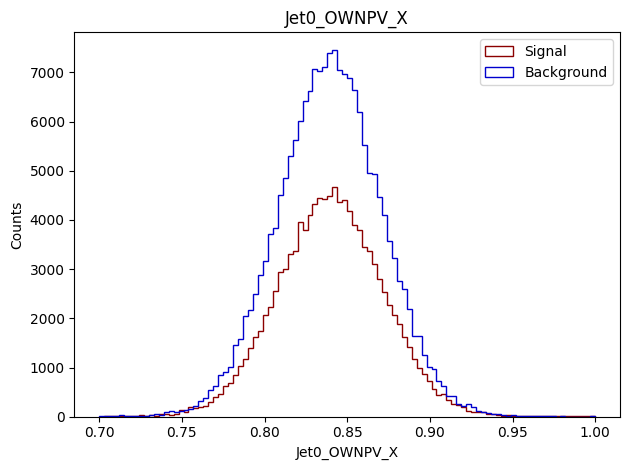

In [ ]:
make_plots('Jet0_OWNPV_X', 100, [0.7,1], 'linear')

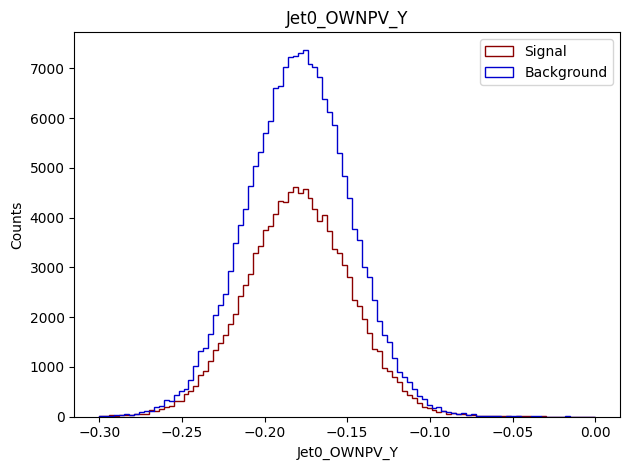

In [ ]:
make_plots('Jet0_OWNPV_Y', 100, [-0.3,0], 'linear')

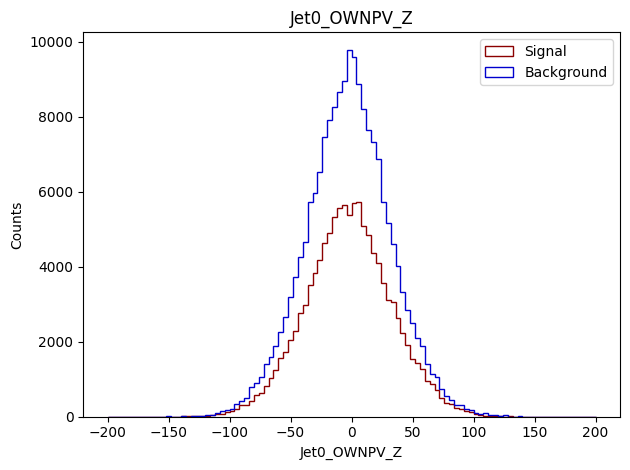

In [ ]:
make_plots('Jet0_OWNPV_Z', 100, [-200,200], 'linear')

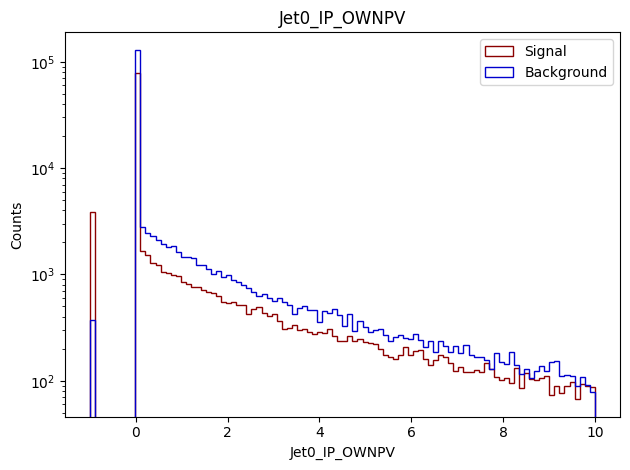

In [ ]:
make_plots('Jet0_IP_OWNPV', 100, [-1,10], 'log')

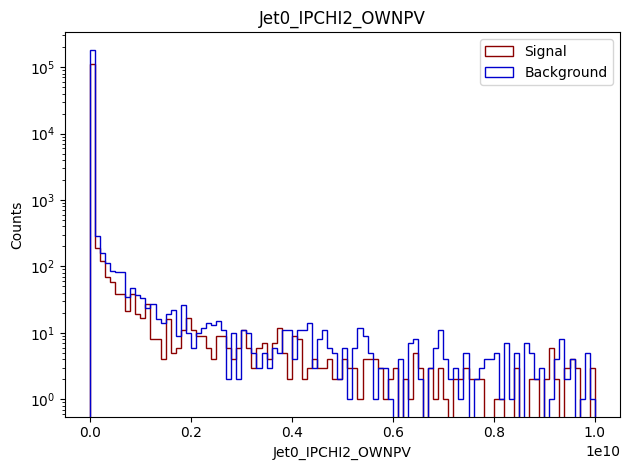

In [ ]:
make_plots('Jet0_IPCHI2_OWNPV', 100, [-0.01,1e10], 'log')

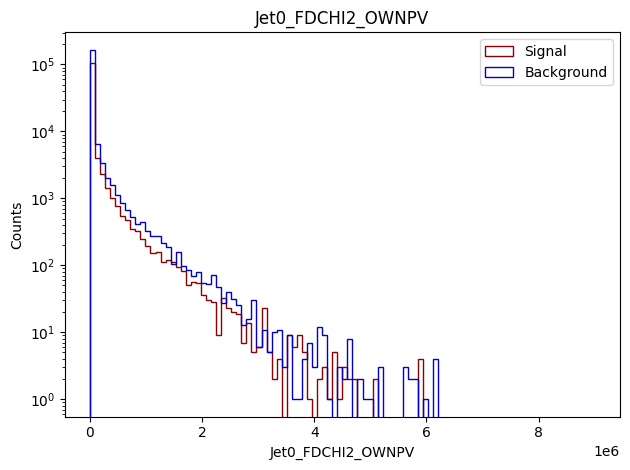

In [ ]:
make_plots('Jet0_FDCHI2_OWNPV', 100, [0,9e6], 'log')

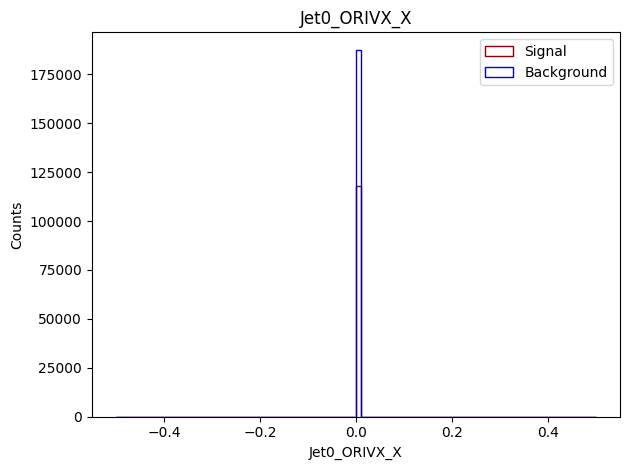

In [ ]:
make_plots('Jet0_ORIVX_X', 100, None, 'linear')

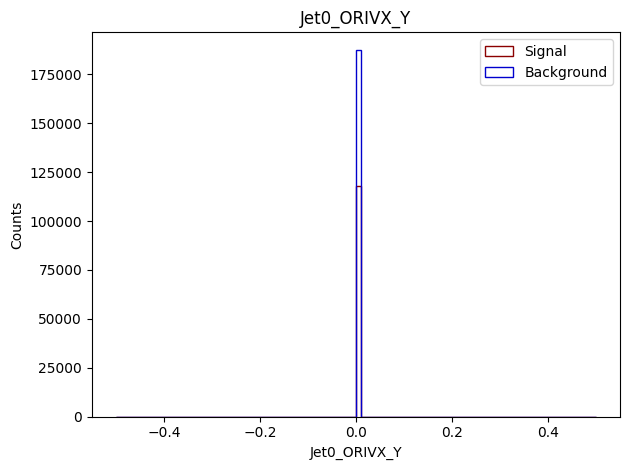

In [ ]:
make_plots('Jet0_ORIVX_Y', 100, None, 'linear')

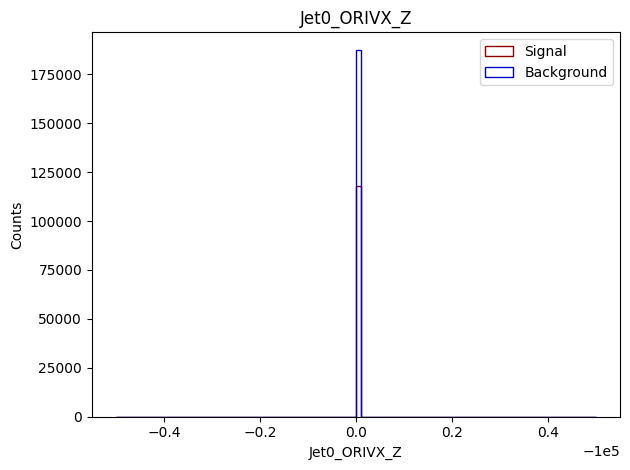

In [ ]:
make_plots('Jet0_ORIVX_Z', 100, None, 'linear')

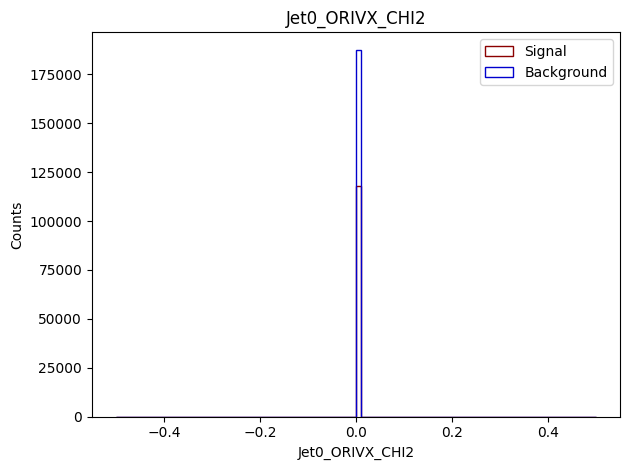

In [ ]:
make_plots('Jet0_ORIVX_CHI2', 100, None, 'linear')

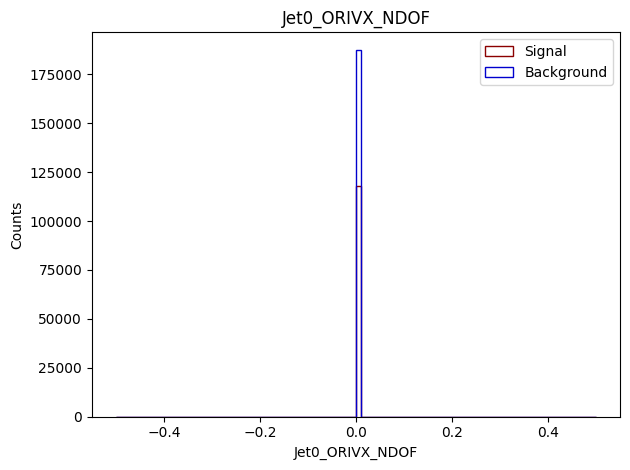

In [ ]:
make_plots('Jet0_ORIVX_NDOF', 100, None, 'linear')

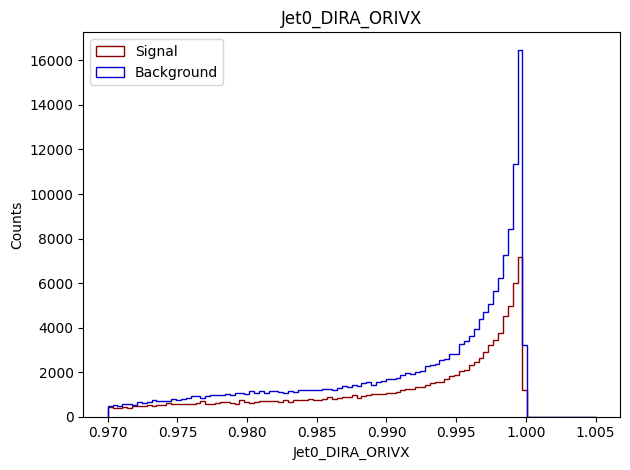

In [ ]:
make_plots('Jet0_DIRA_ORIVX', 100, [0.97 ,1.005], 'linear')

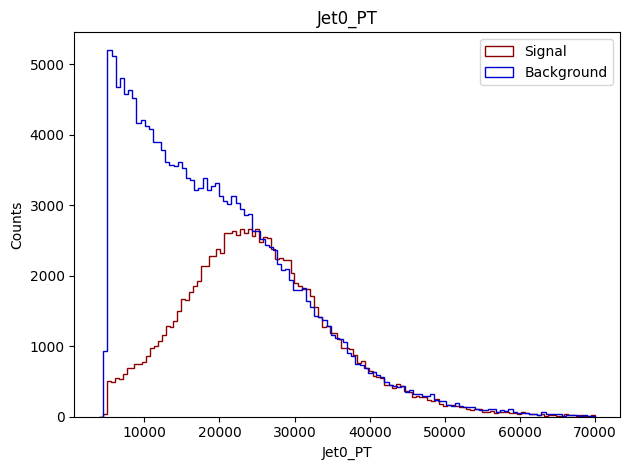

In [ ]:
make_plots('Jet0_PT', 'auto', [4000,70000], 'linear')

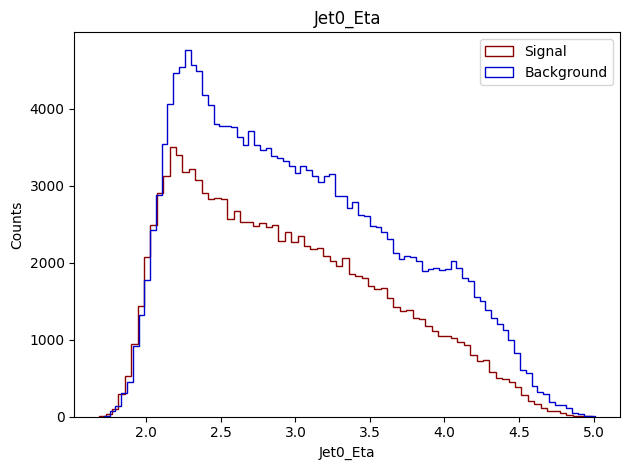

In [ ]:
make_plots('Jet0_Eta', 'auto', None, 'linear')

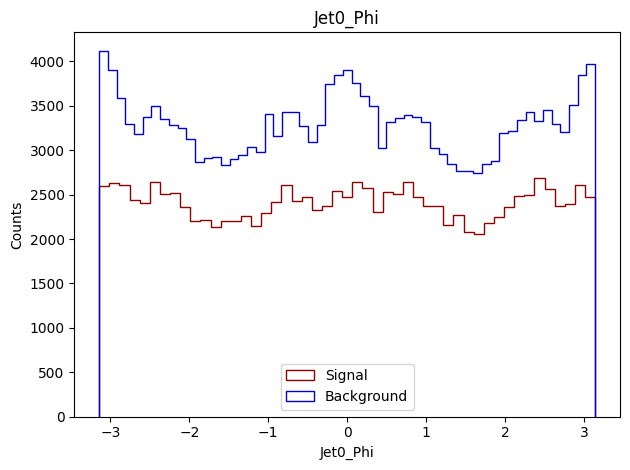

In [ ]:
make_plots('Jet0_Phi', 'auto', None, 'linear')